# **Dice number classification algorithm**

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [1]:
import os
import csv
import cv2 as cv
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

import generateDataset as db

Using TensorFlow backend.


# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [ ]:
def separate_array(data):    
    image = []
    labels = []
    for line in data:
        image.append(np.array(line[:-1]))
        labels.append(line[-1])
    
    return image, labels

In [ ]:
X_train, Y_train = separate_array(np.load('./train_classes.npy'))

In [ ]:
X_validation, Y_validation = separate_array(np.load('./validation_classes.npy'))

In [ ]:
X_test, Y_test = separate_array(np.load('./test_classes.npy'))

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [8]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = range(1,7)

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **KK Neighborhod algorithm**

In [9]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [ ]:
def train_knnModel(i):
    # Train on the first N train images
    train_x = create_number_list(X_train)
    train_y = np.array(Y_train)
    
    #Train the classifier
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN Model with " + str(i) + " neighbors")
    return clf.fit(train_x, train_y)

knn_classificator = train_knnModel(6)

In [ ]:
def visualize_train_knnModel():
    # Visualize on the N test images:
    train_x = create_number_list(X_train)
    train_y = np.array(Y_train) 
    predicted = knn_classificator.predict(train_x)
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(train_y, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(train_x)) + " images")
    
    plot_confusion_matrix(knn_classificator, train_x, train_y)
    plt.show()

visualize_train_knnModel()

In [ ]:
def validation_knnModel():
    # Validate on the validation set:
    validation_x = create_number_list(X_validation)
    validation_y = np.array(Y_validation) 
    predicted = knn_classificator.predict(validation_x)
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(validation_y, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(validation_x)) + " images")
    
    plot_confusion_matrix(knn_classificator, validation_x, validation_y)
    plt.show()

validation_knnModel()

# PHOTOS :D

In [11]:
X_photos, Y_photos = separate_array(np.load('./test_photos_classes.npy'))

The accuracy for the PHOTOS taken is: 26.21%
Using: 8100 photos taken


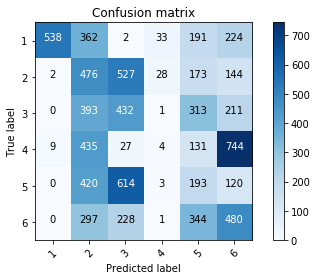

In [12]:
#Testing this new classificator accuracy with the photos taken
def test_photos():
    # Validate on the validation set:
    photos_x = create_number_list(X_photos)
    photos_y = np.array(Y_photos) 
    predicted = knn_classificator.predict(photos_x)
    print("The accuracy for the PHOTOS taken is: " + str(round((accuracy_score(photos_y, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(photos_x)) + " photos taken")
    
    plot_confusion_matrix(knn_classificator, photos_x, photos_y)
    plt.show()

test_photos()

# PHOTOS FIRST TRY

In [14]:
%%time 

X_photos_notNorm, Y_photos = db.create_data_file('./test_photos.npy')
X_photos = db.normalize(X_photos_notNorm)

Creating dataset...

Finished creating dataset

CPU times: user 1min 38s, sys: 231 ms, total: 1min 38s
Wall time: 1min 38s


In [15]:
from collections import Counter
Counter(Y_photos)

Counter({1.0: 1350, 2.0: 1350, 3.0: 1350, 4.0: 1350, 5.0: 1350, 6.0: 1350})

In [16]:
df_photos = db.join_data(X_photos, Y_photos)

In [17]:
db.remove_file('./test_photos_classes.npy')
print("Created photos database")
np.save('./test_photos_classes', df_photos.to_numpy())

Removing ./test_photos_classes.npy
Created photos database


# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [14]:
# Define the parameter values that should be searched
k_range = list(range(2, 10))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [15]:
%%time

# This block is done both grid and random search for the hyperparameters for N numbers

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

train_x = create_number_list(X_train)
train_y = np.array(Y_train)

for i in list(range(15)):
    print("Iteration num: " + str(i))
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(train_x, train_y)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(train_x, train_y)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Iteration num: 0
Iteration num: 1


Process PoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-11:
Process PoolWorker-10:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/morooka

KeyboardInterrupt: 

In [ ]:
rand_best_estimator[np.argmax(rand_best_scores)]

In [ ]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# BEST KNN Classifier

In [ ]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():
    train_x = create_number_list(X_train)
    train_y = np.array(Y_train)
    
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(train_x, train_y)

In [ ]:
#Testing this new classificator accuracy with MNIST database 
def test_database(clf):
    test_x = create_number_list(X_test)
    test_y = np.array(Y_test) 

    predicted = clf.predict(test_x)
    
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(test_y, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(X_test)) + " images in the test")

    plot_confusion_matrix(clf, test_x, test_y)



In [ ]:
#Testing this new classificator accuracy with the photos taken
def new_test_photos(clf, N):
    test_x_photos, test_y_photos = read_test()

    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy for photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")

    print("Using: " + str(N) + " images to train")
    print("Using: " + str(len(test_x_photos)) + " photos taken")

    plot_confusion_matrix(clf, test_x_photos, test_y_photos)



In [ ]:
best_knn_classificator = train_best_classifier(200)


In [ ]:
test_database(best_knn_classificator, 200)


In [ ]:
new_test_photos(best_knn_classificator, 200)

# RASCUNHO!!!!!!!!!!!!!!!!!!

In [ ]:
def read_photos(data):    
    image = []
    labels = []
    for line in data:
        image.append(np.array(line[:-1]))
        labels.append(line[-1])
    
    return image, labels

In [13]:
test_x_photos, test_y_photos = read_photos(photos) 

In [ ]:
test_x_photos, test_y_photos = read_photos(photos) 

The accuracy for photos taken is: 11.306%
Using: 13320 images


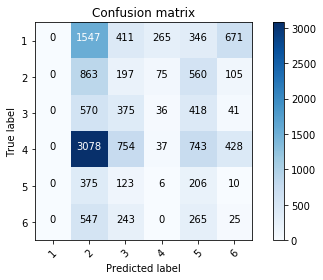

In [56]:
def test_photos_knnModel():
    #New set of values
    test_x_photos, test_y_photos = read_photos(photos) 
    predicted_photos = knn_classificator.predict(test_x_photos)
    
    print("The accuracy for photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")
    print("Using: " + str(len(test_y_photos)) + " images")
    
    plot_confusion_matrix(knn_classificator, test_x_photos, test_y_photos)
    plt.show()

test_photos_knnModel()

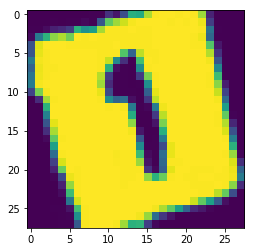

In [14]:
for i in range(len(test_x_photos)):
    if test_y_photos[i] == 1:
        plt.imshow(np.asarray(test_x_photos[i]).reshape(28,28))
        break

In [ ]:
%%time

# This function creates the test set of photos
def create_test():    
    #Load the database (.npy) files 
    img_array_train = np.load('./../train.npy')
    img_array_test = np.load('./../test.npy')
    img_array_validation = np.load('./../validation.npy')

    #Transform it in pandas dataframe
    df_train = pd.DataFrame(img_array_train)
    df_test = pd.DataFrame(img_array_test)
    df_validation = pd.DataFrame(img_array_validation)

    # Create only one set of data
    df = df_train.append(df_test).append(df_validation) 
    photos = df.to_numpy()
    
    if os.path.isfile('initial_test.csv'):
        os.remove('initial_test.csv')
    else:
        print 'Test file does not exist'
            
    image_traitement(photos[0:5])
    
create_test()